# <center> Практическое задание №2 </center>

**Задание**: Реализовать пороговый классификатор который определит: на каких интервалах аудиозаписи есть выстрел, а на каких нет


In [481]:
#!pip install librosa == 0.10.0
from scipy.fft import fft, rfft, irfft, rfftfreq
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import scipy

## Пороговый классификатор для дектектирования выстрела

Загрузим аудиозапись и прослушаем ее

In [3]:
shot, shot_sr = librosa.core.load("Стрельба на улице.wav")
print(f"Len is {len(shot)} samples. Sample rate is {shot_sr}")
player = ipd.Audio(shot, rate=shot_sr)
ipd.display(player)

Len is 350354 samples. Sample rate is 22050


Отрисуем сигнал во временной области

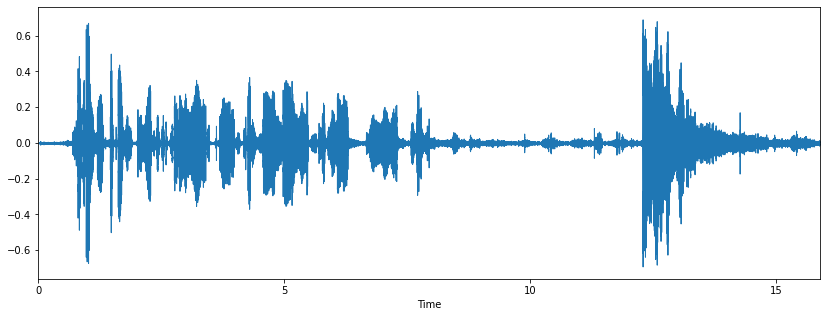

In [29]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(shot, sr=shot_sr)

In [455]:
def gun_detection(wav, sr, window_ms=1000, step_ms=1000, window='hann', threshold = 3):
  
  # переходим от мс к отсчетам
  n_fft = window_ms * sr//1000
  hop_length = step_ms * sr//1000

  # применяем оконное преобразование фурье с размером окна n_fft, шагом hop_length, и оконной функцией window
  # получаем спектры на каждом окне
  wav_stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, window = window)

  # считаем среднюю энергию спектра на каждом окне
  energy = np.mean(np.abs(wav_stft), axis = 0)
  # print(energy)

  #отрисовка графика для подбора параметров
  plt.figure(figsize=(10, 5))
  plt.title("Средняя энергия сигнала по окнам")
  plt.step(np.arange(len(energy)),energy)
  plt.grid()

  # сравниваем энергию на каждом окне с порогом, ответ масштабируем на всю длину wav
  energy = np.repeat(energy, hop_length)
  ans = np.zeros_like(energy)
  ans[energy > threshold] = 1
            
  return ans[:len(wav)]

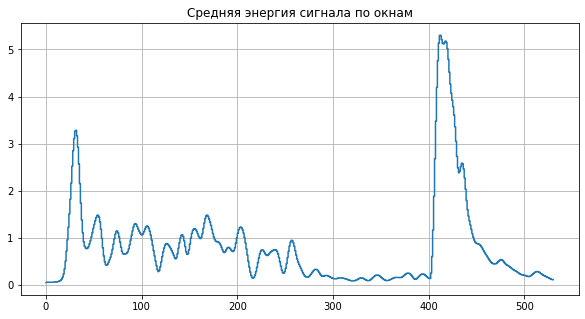

In [464]:
frame_size = 500 #ms
hop_size = 30 #ms
window='hann'
threshold = 3.3
shot_en = gun_detection(shot, shot_sr, window_ms=frame_size, step_ms=hop_size, window=window, threshold = threshold)

Продемонстрируем результаты работы классификатора

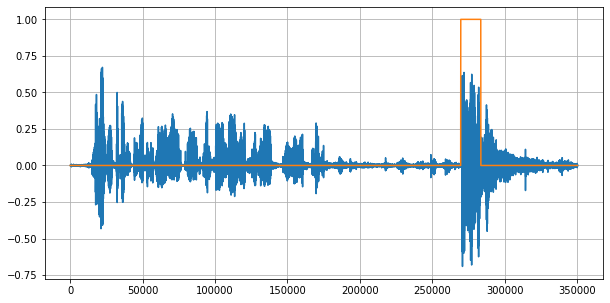

In [457]:
  plt.figure(figsize=(10, 5))
  plt.plot(shot)
  plt.plot(shot_en)
  plt.grid()

Оставим на аудиозаписи только выстрел

In [458]:
shot_start = np.nonzero(shot_en)[0][0]
shot_end = np.nonzero(shot_en)[0][-1]
shot_only = shot[shot_start:shot_end+1]

In [459]:
player = ipd.Audio(shot_only, rate=shot_sr)
ipd.display(player)

## Эксперименты с фильтрами

Посмотрим на спектры с выстрелом и без него

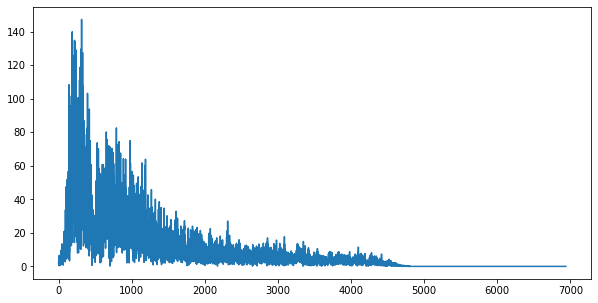

In [468]:
#выстрел
shot_spec = scipy.fft.fft(shot_only)
plt.figure(figsize=(10, 5))
plt.plot(np.abs(shot_spec[:len(shot_spec)//2]))

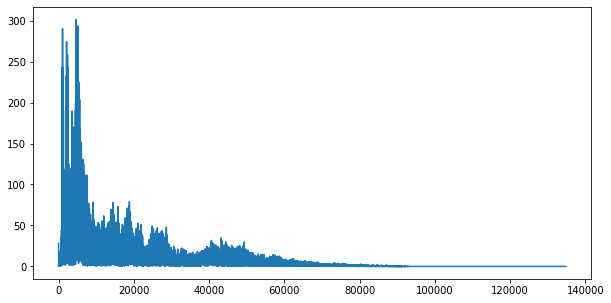

In [471]:
#до выстрела
plt.figure(figsize=(10, 5))
noise_spec = scipy.fft.fft(shot[:shot_start])
plt.plot(np.abs(noise_spec[:len(noise_spec)//2]))

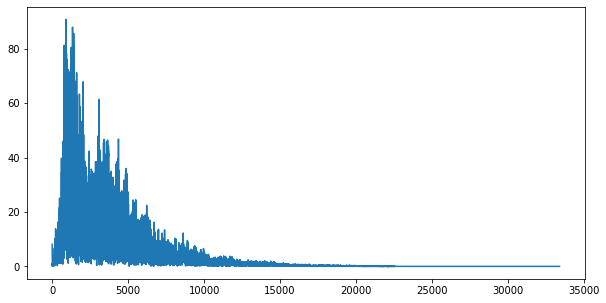

In [472]:
#после выстрела
plt.figure(figsize=(10, 5))
noise_spec_2 = scipy.fft.fft(shot[shot_end:])
plt.plot(np.abs(noise_spec_2[:len(noise_spec_2)//2]))

In [530]:
from scipy import signal
freq_threshold = 4000
b, a = signal.butter(8, 2*freq_threshold/shot_sr, 'lowpass')   # Конфигурационный фильтр 8 указывает порядок фильтра
shot_filtred = signal.filtfilt(b, a, shot)

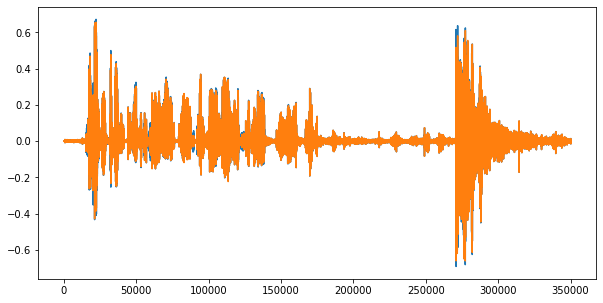

In [531]:
plt.figure(figsize=(10, 5))
plt.plot(shot)
plt.plot(shot_filtred)

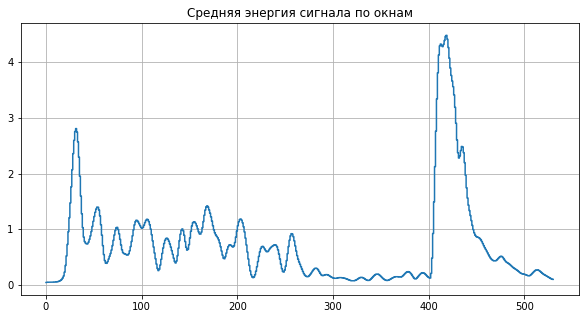

In [534]:
frame_size = 500 #ms
hop_size = 30 #ms
window='hann'
threshold = 3
shot_en = gun_detection(shot_filtred, shot_sr, window_ms=frame_size, step_ms=hop_size, window=window, threshold = threshold)

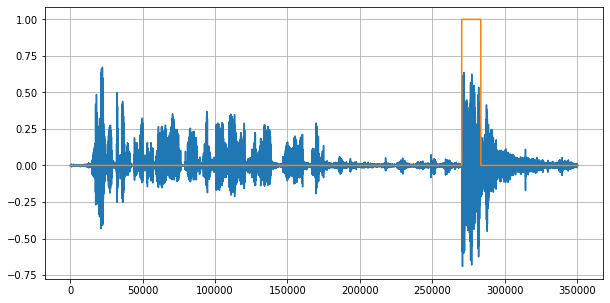

In [535]:
plt.figure(figsize=(10, 5))
plt.plot(shot)
plt.plot(shot_en)
plt.grid()